# Biathlon Data Science Project

* Data source: Real Biatholon Statistics [link](http://www.realbiathlon.com/p/statistics-women.html)
* 2015-2016 Season Biathlon World Cup Womens Shooting Times: [link](http://realbiathlon.sportsontheweb.net/data2/WomenShootingTimes_files/sheet016.htm)
* 2015-2016 Season Biathlon World Cup Womens Results: [link](http://realbiathlon.sportsontheweb.net/data2/WomenResults_files/sheet016.htm)

## Definition of Features

From the metadata on the data source we have the following definition of the features.

*From "shooting_time.csv"*

| Feature  | Description |
|--------------|-------------|
|  Family Name  | Last Name|
|  Given Name  | First Name|
|  Races  |  Number of individual, non-relay races each person competed in over the 2015-16 season|
|  Rg_Time_S |  Average Time for individual to get into standing position, shoot and get out of position, otherwise known as Range Time to shoot Standing|
|  Rg_Time_P |  Average Time for individual to get into prone position, shoot, and get out of position, otherwise known as Range Time to shoot Prone|
|  Penalty Loop  |  Season average penalty loop (approximation)|

*From "skiing_performance.csv"*

| Feature  | Description |
|--------------|-------------|
|  Km/h  |  season's average ski speed in km/h|

*From "shooting_percentage.csv"*

| Feature  | Description |
|--------------|-------------|
|  Hits  |  Number of targets hits|
|  Shots  |  Number of total targets the individual could have hit (Or wanted to hit to not ski any penalty loops)|
|  P%  |  Average percentage of Prone targets hit|
|  S%  |  Average percentage of Standing Targets hit|


## What we can do next
<input type="checkbox">  Merge shooting time dataframe with results dataframe to create a target for training our model. Add average rank and world cup points as columns from results file.

<input type="checkbox">  Statistical analysis -- what is the spread of each category? Create a new column of Hits/ Shots (Shooting Percentage) and get rid of % P and % S. Vizualize this

<input type="checkbox">  Feature selection -- What categories might contribute more to the final ranking? ("Skiing is for show, shooting is for dough")

<input type="checkbox">  Train a model to predict placement. How accurate is it? Would combining data from different years yield better results?

<input type="checkbox">  How have the categories changed throughout the years? Is the sport getting more competitive?

### Merging Dataframes

* Compare statistics for Fastest Skiers and Shooting percentages/shooting times
* Concat First + Last name


In [1]:
import pandas as pd
import matplotlib.pyplot as plt      # matplotlib.pyplot plots data
import seaborn as sns
import datetime

%matplotlib inline

The dataset already contains an index column. We can either set this column as the index in our data frame, our we can choose to drop the first column in our dataset. I am doing the former below. Further, we see a large number of NaN's. Let's go ahead and convert these to 0:00.0 to be consistent. While we're at it, let's also rename the columns to something less confusing.

In [2]:
df_sh_times = pd.read_csv("shooting_time.csv", index_col=0)
df_sh_times = df_sh_times.fillna('0:00.0')
df_sh_times = df_sh_times[['Family Name', 
                           'Given Name', 
                           'Races', 
                           'Rg Time\nP', 
                           'Rg Time\nS', 
                           'Penalty\nLoop' ]]

df_sh_times = df_sh_times.rename(columns={'Rg Time\nP': 'Rg_Time_P',
                                          'Rg Time\nS': 'Rg_Time_S',
                                          'Penalty\nLoop': "Penalty Loop"})
df_sh_times.head()

,Family Name,Given Name,Races,Rg_Time_P,Rg_Time_S,Penalty Loop
1,KAISHEVA,Uliana,1,0:41.8,0:41.7,0:26.0
2,KUMMER,Luise,6,0:48.1,0:45.9,0:26.4
3,HAUSER,Lisa Theresa,24,0:48.3,0:43.6,0:25.3
4,ZDOUC,Dunja,11,0:49.5,0:45.1,0:25.8
5,WIERER,Dorothea,25,0:47.2,0:44.9,0:23.5


We see that the times are stored as string. Let's write a function to convert each of the times to total seconds.

In [3]:
def str_to_sec(val):
    minute, seconds = val.split(":")
    sec, msec = seconds.split(".")
    total_sec = int(minute)*60 + int(sec) + int(msec)/10
    return total_sec

In [4]:
for c in df_sh_times.columns[3::]:
    df_sh_times[c] = df_sh_times[c].apply(lambda x: str_to_sec(x))

df_sh_times['Family Name'] = df_sh_times['Family Name'].apply(lambda x: x.capitalize()) + " " + df_sh_times['Given Name']   
df_sh_times = df_sh_times.drop(["Given Name"], axis=1)
df_sh_times.head()

,Family Name,Races,Rg_Time_P,Rg_Time_S,Penalty Loop
1,Kaisheva Uliana,1,41.8,41.7,26.0
2,Kummer Luise,6,48.1,45.9,26.4
3,Hauser Lisa Theresa,24,48.3,43.6,25.3
4,Zdouc Dunja,11,49.5,45.1,25.8
5,Wierer Dorothea,25,47.2,44.9,23.5


Much better! Now that the data is in a more workable format, let's dive deeper into what the dataset looks like. Some things we might be interested in include the shape, a summary of each column (number of entries, data types etc), and a correlation matrix to pick out any redundancies.

In [5]:
# Look at the shape of the dataframe (number of rows and columns)
print("The shooting times data set now has {rows} rows and {cols} columns after cleaning".format(rows=df_sh_times.shape[0], 
                                                                cols=df_sh_times.shape[1]))

The shooting times data set now has 165 rows and 5 columns after cleaning


In [6]:
# look a a summary of each column (number of entries, data-type etc)
df_sh_times.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 1 to 165
Data columns (total 5 columns):
Family Name     165 non-null object
Races           165 non-null int64
Rg_Time_P       165 non-null float64
Rg_Time_S       165 non-null float64
Penalty Loop    165 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.7+ KB


In [7]:
# Check for any null values
df_sh_times.isnull().values.any()

False

In [8]:
# Now read in the skiing performance data set
df_ski = pd.read_csv("skiing_performance.csv", index_col=0)
df_ski = df_ski[['Family Name', 'Given Name', 'km/h']]
df_ski['Family Name'] = df_ski['Family Name'].apply(lambda x: x.capitalize()) + " " + df_ski['Given Name']
df_ski = df_ski.drop(["Given Name"], axis=1)

df_ski.head()

,Family Name,km/h
1,Makarainen Kaisa,24.08
2,Dorin habert Marie,23.85
3,Eckhoff Tiril,23.74
4,Dahlmeier Laura,23.70
5,Goessner Miriam,23.89


In [9]:
df_ski.isnull().values.any()

False

In [10]:
# Now read in the skiing performance data set
df_sh_per = pd.read_csv("shooting_percentage.csv", index_col=0)
df_sh_per = df_sh_per[['Family Name', 'Given Name', 'Hits', 'Shots', 'P\n %', 'S\n%']]
df_sh_per['Family Name'] = df_sh_per['Family Name'].apply(lambda x: x.capitalize()) + " " + df_sh_per['Given Name']
df_sh_per = df_sh_per.drop(["Given Name"], axis=1)

df_sh_per.head()

,Family Name,Hits,Shots,P %,S %
1,Kupfner Simone,10,10,100.0,100.0
2,Kadeva Daniela,10,10,100.0,100.0
3,Vaillancourt Audrey,19,20,90.0,100.0
4,Runggaldier Alexia,87,93,95.7,91.5
5,Skardino Nadezhda,365,394,92.4,92.9


In [11]:
df_sh_per.isnull().values.any()

False

In [12]:
df = df_sh_per.merge(df_ski, left_on='Family Name', right_on='Family Name')
df = df_sh_times.merge(df, left_on='Family Name', right_on='Family Name')

df.head()

,Family Name,Races,Rg_Time_P,Rg_Time_S,Penalty Loop,Hits,Shots,P %,S %,km/h
0,Kaisheva Uliana,1,41.8,41.7,26.0,8,10,100.0,60.0,22.32
1,Kummer Luise,6,48.1,45.9,26.4,107,125,87.1,84.1,22.17
2,Hauser Lisa Theresa,24,48.3,43.6,25.3,434,486,90.9,87.7,22.64
3,Zdouc Dunja,11,49.5,45.1,25.8,201,237,84.2,85.5,21.94
4,Wierer Dorothea,25,47.2,44.9,23.5,431,496,91.4,82.5,23.35


In [18]:
df.isnull().values.any()
df.shape

(165, 10)

In [14]:
# Look at the shape of the merged dataframe (number of rows and columns)
print("The shooting times data set now has {rows} rows and {cols} columns after cleaning".format(rows=df.shape[0], 
                                                                cols=df.shape[1]))

The shooting times data set now has 165 rows and 10 columns after cleaning


In [15]:
def plot_pretty_corr(df):
    plt.figure(figsize=(12, 12))
    corr = df.corr()
    ax = sns.heatmap(corr,
                    vmin=-1,
                    vmax=1,
                    center=0,
                    cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

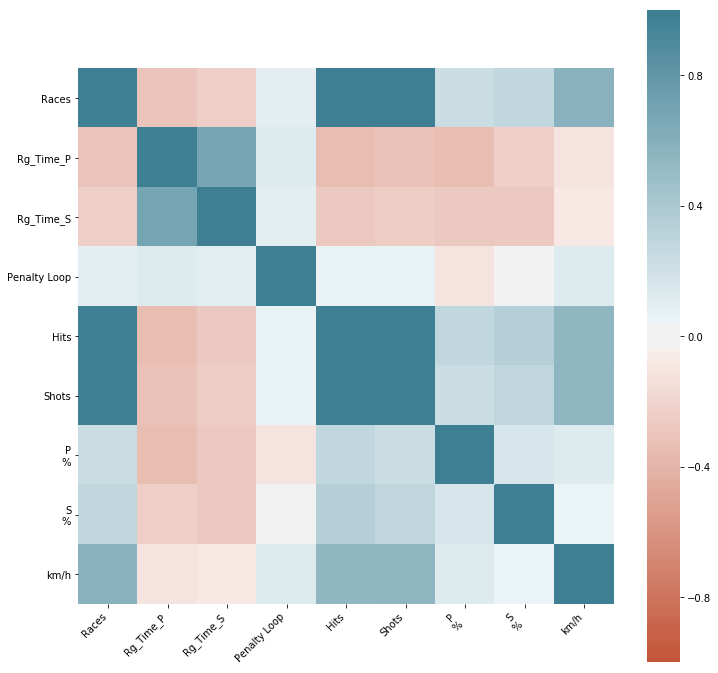

In [19]:
plot_pretty_corr(df)

Hits on shots seem to correlate perfectly. Is there an opputunity to reduce dimensions here?